# Election Poll example
Two candidates A and B face each other in the election. We run a fictitious poll by surveying $n=20$ voters. The result is that $y=9$ will vote for A and $n-y=11$ will vote for B.

We ask ourselves two questions:
* **Question 1:** How to evaluate the probability that A will be elected?
* **Question 2:** If we survey an (n+1)-th voter, what is the probability that they will vote for A?

To answer these questions we'll estimate the posterior distribution of the proportion of voters that will vote for A. Question 1 is then about estimating how likely it is that the proportion is larger than 50%, while question 2 is about estimating the mean value of that proportion.

In the following we'll estimate the posterior density using first exact inference, then markov chain monte carlo.

## 1. Defining the model

Let $\mu\in[0,1]$ be the unknown proportion of voters that will vote for A.

* Suppose a uniform **prior** on $\mu$: $p(\mu) = 1$
* The **likelihood** for the number of voters for A is binomial: $p(y| \mu)=\mathrm{Binom}(n, \mu)(y)\propto \mu^y (1-\mu)^{n-y}$

## 2. Exact inference 
The posterior is in this case a Beta distribution: $$p(\mu| y) = \mathrm{Beta}(y+1, n+1-y)(\mu)$$
### 2.1 Beta distribution reminder
* Density: $\mathrm{Beta}(\mu, a, b) = \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)} \mu^{a-1} (1-\mu)^{b-1}$
* Expected value: $\mathbb{E}[\mu] = \frac{a}{a+b}$
* Variance: $\mathrm{var}= \frac{ab}{(a+b)^2(a+b+1)}$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import pymc3 as pm
from scipy import stats

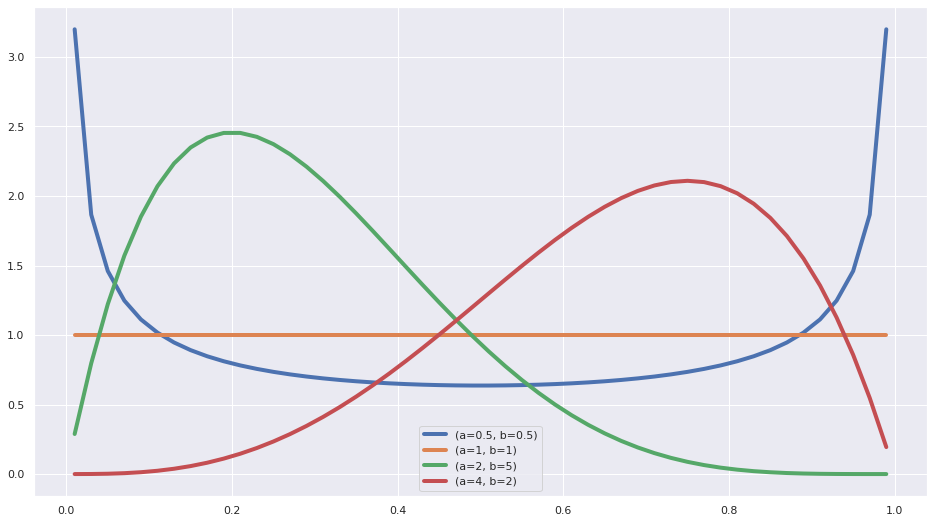

In [6]:
x = np.linspace(0.01, 0.99)
ab_pairs = [(0.5,0.5), (1, 1), (2,5), (4, 2)]
fig = plt.figure(figsize=(16,9))
for a,b in ab_pairs:
    y = stats.beta.pdf(x, a, b)
    plt.plot(x,y, label=f"(a={a}, b={b})", lw=4)
plt.legend();

* We see that for values of a and b smaller than 1, the pdf has a U shape. 
* For a=1 and b=1 it's a uniform distribution
* When b is larger than a it's skewed to the left
* When a is larger than b it's skewed to the right

### 2.2 Probability that A wins the election
Probability that A wins the election boils down to computing $P(\mu > 0.5 | y)$. We can compute it analytically by specifying a beta distribution with the correct parameters using scipy's stats module.

In [7]:
n, y = 20, 9
posterior = stats.beta(y+1, n+1-y)
prob_a_wins = 1 - posterior.cdf(0.5)
print(f"Probability that A wins : {prob_a_wins}")

Probability that A wins : 0.33181190490722623


We can now also compute a 95% credible interval $I$ for the probability that A will win: $p(\mu\in I)=0.95$.
We can use the percentile point function (inverse cdf) from scipy to find the interval. In this case $I=[0.26, 0.66]$

In [11]:
posterior.ppf(0.975)

0.6597936907197253

In [12]:
posterior.ppf(0.025)

0.2571306264064069

### 2.3 Probability that a new voter will vote for A
Question 2 requires us to compute the probability that some new voter will vote for A given the results of the survey. This means $p(\mathrm{vote\ for\ A}|y) = \int_0^1 p(\mathrm{vote\ for\ A}|\mu)p(\mu|y)\mathrm{d}\mu = \int_0^1 \mu p(\mu|y)\mathrm{d}\mu = \mathbb{E}[\mu|y] = \frac{y+1}{(y+1) + (n+1-y)} \approx 0.45$

In [14]:
print(f"Probability of a vote for A given the survey result: {posterior.mean()}")

Probability of a vote for A given the survey result: 0.45454545454545453


## 3. Election poll using pymc3
With pymc3 we can avoid all of the analytical computation, giving us more flexibility. Here's how we'd set up the model and come up with the same answer by simulation.

In [15]:
num_trials, observed_votes_for_a = 20, 9
with pm.Model() as poll_model:
    # Prior
    mu = pm.Uniform("mu", 0, 1)
    # Likelihood
    num_votes_for_a = pm.Binomial("y", n=num_trials, p=mu, observed=observed_votes_for_a)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:00<00:00, 6492.60draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf7478f6a0>],
      dtype=object)

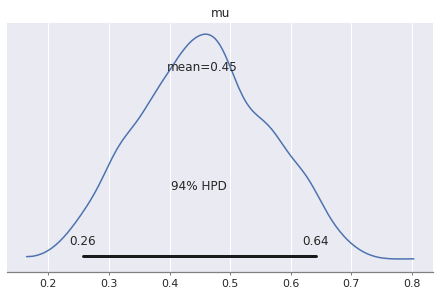

In [16]:
pm.plot_posterior(trace)

We see the same mean and pretty much the same credibility interval we computed analytically.

It's kind of an inconvenience (in my opinion) not to have a compact representation of the posterior but only samples instead. However this is sometimes all we can hope for in a more complicated, non-conjugate model.

Here's how we would work with the samples to answer question 2:

In [21]:
print(trace.varnames)

['mu_interval__', 'mu']


In [26]:
trace['mu'].shape

(2000,)

In [28]:
print(f"Probability of a vote for A given the survey result: {trace['mu'].mean()}")

Probability of a vote for A given the survey result: 0.4547869552584988


Finally let's compare the true posterior density to the sample histogram obtained by Monte Carlo sampling

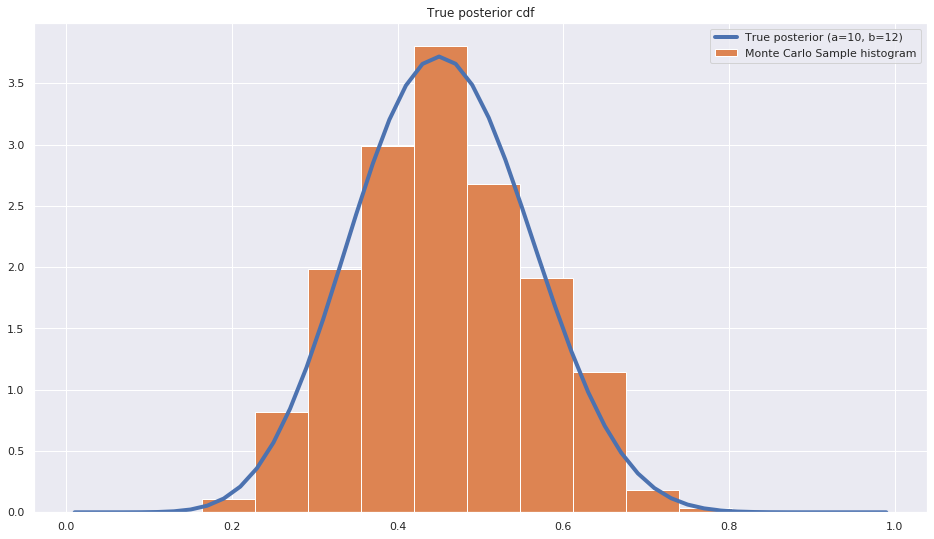

In [36]:
fig = plt.figure(figsize=(16,9))
y = posterior.pdf(x)
plt.plot(x,y, label=f"True posterior (a={observed_votes_for_a+1}, b={num_trials+1-observed_votes_for_a})", lw=4);
plt.hist(trace['mu'], density=True, label="Monte Carlo Sample histogram")
plt.title('True posterior cdf')
plt.legend();